In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
counts = pd.read_csv('~/Google Drive/Research Projects/Finished/Power-analysis/Public data/GSE60768/GSE60768_umi_counts.csv', index_col=0)

counts = counts.astype(int)

sample_info = pd.DataFrame({'condition': counts.columns.str.split('_').str.get(1)}, index=counts.columns)

sample_info['total_counts'] = counts.sum()
sample_info['num_genes'] = (counts > 0).sum()
sample_info['ERCC'] = counts[counts.index.str.startswith('ERCC-')].sum()

In [3]:
sample_info.condition.value_counts()

ESC    48
NSC    48
2i     48
Name: condition, dtype: int64

If you have two types of cells, you might want to find what molecular features distinguish them from each other. A popular assay for this is RNA-sequencing. If you measure the RNA from different genes in the two cell types, you can identify which RNAs are more abundant in one cell type or the other. This is known as _differential expression_ (DE) analysis, and we usually say that genes are _upregulated_ or _downregulated_ depending if they are more or less abundant. (I'd argue "enriched" or "depleted" would be better terms, because "regulated" suggests some causality you're not measuring.)

Abstracting away many details about normalisation and data noise, say $ x^g $ is the gene expression, and $ y $ be and indicator of cell type such that $ y = 1 $ for one, and $ y = -1 $ for the other. In differential expression analysis, for every gene $ g $ we investigate the relation
$$
x^g = \beta_0^g + \beta_1^g \cdot y + \varepsilon
$$

with regards to the data, and ask the question of whether $ \beta_1^g $ is different from zero in a meaningful way.

To make the example more concrete, let's consider the data from Velten et al, where the authors studied mES cells ($ N = 96 $) and NS cells ($ N = 48 $). Say that $ y = 1 $ for mESC, and $ y = -1 $ for NSC. For example, if $ \beta_1^g $ is postive the gene is more abundant in mESCs, and the magnitude of $ \beta_1^g $ is the _effect size_.

For this simple example, let's investigate 200 genes from the data (selected by having high variance) with expression on a log scale. For the sake of simplicity, let's assume normal distributed noise $ \varepsilon \sim \mathcal{N}(0, \sigma^2_g) $.

The model described above can be implemented in Stan in the following way

    data {
      int<lower=0> N;
      int<lower=0> G;
      matrix[N, G] X;
      vector[N] y;
    }
    parameters {
      vector[G] beta0;
      vector[G] beta;
      real<lower=0> sigma[G];
    }
    model {

      beta ~ normal(0, 1.);
      beta0 ~ normal(0, 1.);

      for (i in 1:G) {
        col(X, i) ~ normal(beta0[i] + y * beta[i], sigma[i]);
      }

    }

(To keep it simple, we collect all the genes in a matrix and analyse them all at once).

Running the model, we obtain samples from the posterior distribution of the Effect size of each gene ($ \beta_1^g $). We plot the mean of this, with 95% confidence intervals (CI).

In [4]:
import pickle

with open('DE.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [5]:
p = 200
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(p).index
tmp = np.log1p(counts.T[idx])
y = (sample_info['condition'] != 'NSC')
n = tmp.shape[0]

In [6]:
data = {
    'N': n,
    'G': p,
    'X': tmp.values,
    'y': 2 * (y.astype(int).values - 0.5)
}

In [7]:
s = model.sampling(data=data, iter=1000)

In [8]:
beta = s.extract('beta')['beta']

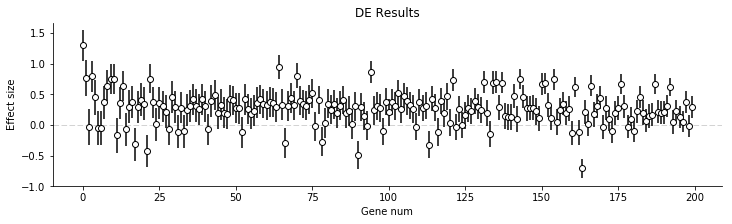

In [9]:
figsize(12, 3)
plt.errorbar(np.arange(beta.shape[1]), beta.mean(0), yerr=2*beta.std(0), fmt='o', color='k', markerfacecolor='w');
plt.axhline(0, lw=1, ls='--', color='lightgrey', zorder=-1)
plt.xlabel('Gene num')
plt.ylabel('Effect size');
plt.title('DE Results');

Several of the 200 genes have effect sizes such that the CI is far away from 0. A handy way to quantify the uncertainty of the effect sizes is to invsetigate the probability of the effect size being 0, let's call this a _P-value_. A simple way to do that in this setting is
$$
 P = \min( p(\beta_1^g < 0 | y, x^g), p(-\beta_1^g < 0 | y, x^g) ).
$$

In other words, we just count how many of the posterior samples are on the wrong side of 0 for the effect size. Comparing the effect size with the P-value is known as a _volcano plot_.

In [10]:
pval = np.sum((beta < 0), 0) / beta.shape[0]
pval = np.minimum(pval, 1 - pval)

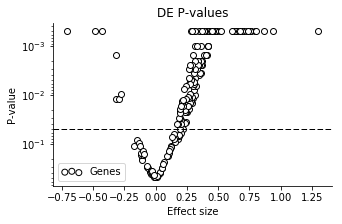

In [11]:
figsize(5, 3)
plt.yscale('log')
plt.scatter(beta.mean(0), np.maximum(pval, 1./beta.shape[0]), c='w', edgecolor='k', label='Genes');
plt.axhline(0.05, lw=1, ls='--', c='k');
plt.gca().invert_yaxis();
plt.ylabel('P-value')
plt.xlabel('Effect size');
plt.legend(scatterpoints=3);
plt.title('DE P-values');

In this case we drew 2,000 samples, which puts a limit to the smallest P-value we can observe as 1 / 2,000, causing the plateau in the figure.

In [12]:
pd.DataFrame({'pval': pval, 'beta': beta.mean(0)}, index=idx).sort_values('pval').head(10)

,beta,pval
ENSMUSG00000060461,1.296872,0.0
ENSMUSG00000091955,0.463096,0.0
ENSMUSG00000028936,0.383841,0.0
ENSMUSG00000063856,0.427333,0.0
ENSMUSG00000067288,0.365123,0.0
ENSMUSG00000033307,0.390917,0.0
ENSMUSG00000028691,0.462913,0.0
ENSMUSG00000063524,0.521403,0.0
ENSMUSG00000079435,0.369893,0.0
ENSMUSG00000049422,0.864710,0.0


The reason I'm writing about this, is that I had a conversation with [Tomás](https://twitter.com/tomsgoms) about this in relation to our notion of cell types.

**It's kind of backwards!**

We had the cell types, and then investigated which genes were expressed in the cells. In essence, from a machine learning perspective, we are assessing if the cell type label can predict the gene expression. But what we _want_ to do is investigate how gene expression predicts cell type!

So can we do it the other way around? Keeping the notation like above, we want to investigate
$$
y = \beta_0 + \sum_{g=1}^G \beta^g \cdot x^g + \varepsilon.
$$

Now, if $ \beta^g $ is positive, the gene will be a predictor for mESC identity, and the magnitude of this will inform about how important it is for determining the cell type. (I think we can still call this _effect size_ in a meaningful way.)

Let's refer to this as _reverse differential expression_, and implement it in Stan in this way:

    data {
      int<lower=0> N;
      int<lower=0> G;
      matrix[N, G] X;
      real y[N];
    }
    parameters {
      real beta0;
      vector[G] beta;
      real<lower=0> sigma;
    }
    model {

      beta ~ normal(0, 1.);
      beta0 ~ normal(0, 1.);

      y ~ normal(beta0 + X * beta, sigma);
    }

After sampling, we can plot the effect sizes of the genes like above.

In [13]:
import pickle

with open('LR.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [14]:
p = 200
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(p).index
tmp = np.log1p(counts.T[idx])
y = (sample_info['condition'] != 'NSC')
n = tmp.shape[0]

In [15]:
data = {
    'N': n,
    'G': p,
    'X': tmp.values,
    'y': 2 * (y.astype(int).values - 0.5)
}

In [16]:
s = model.sampling(data=data, iter=1000)

In [17]:
beta = s.extract('beta')['beta']

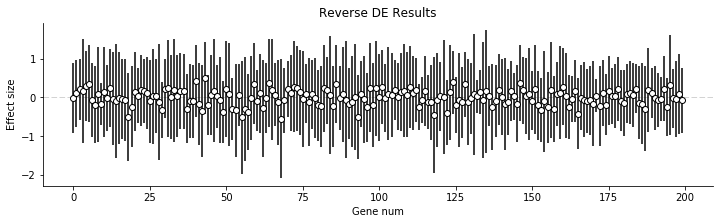

In [18]:
figsize(12, 3)
plt.errorbar(np.arange(beta.shape[1]), beta.mean(0), yerr=2*beta.std(0), fmt='o', color='k', markerfacecolor='w');
plt.axhline(0, lw=1, ls='--', color='lightgrey', zorder=-1)
plt.xlabel('Gene num')
plt.ylabel('Effect size');
plt.title('Reverse DE Results')

The results are not exactly stellar. All effect sizes are quite small, and very uncertain! The P-values illustrate this as well.

In [19]:
pval = np.sum((beta < 0), 0) / beta.shape[0]
pval = np.minimum(pval, 1 - pval)

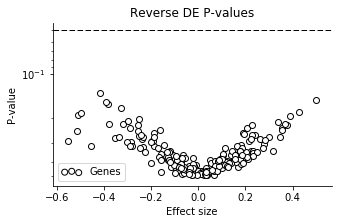

In [20]:
figsize(5, 3)
plt.yscale('log')
plt.scatter(beta.mean(0), np.maximum(pval, 1e-13), c='w', edgecolor='k', label='Genes');
plt.axhline(0.05, lw=1, ls='--', c='k');
plt.gca().invert_yaxis();
plt.ylabel('P-value')
plt.xlabel('Effect size');
plt.legend(scatterpoints=3);
plt.title('Reverse DE P-values')

In [21]:
pd.DataFrame({'pval': pval, 'beta': beta.mean(0)}, index=idx).sort_values('pval').head(10)

,beta,pval
ENSMUSG00000022708,-0.420413,0.1355
ENSMUSG00000038900,0.501867,0.1515
ENSMUSG00000083084,-0.391816,0.1565
ENSMUSG00000046330,-0.386397,0.1600
ENSMUSG00000003429,-0.329270,0.1725
ENSMUSG00000037805,0.425457,0.1815
ENSMUSG00000060126,-0.498119,0.1845
ENSMUSG00000046364,-0.512343,0.1905
ENSMUSG00000021754,0.387441,0.1940
ENSMUSG00000064341,-0.252449,0.2055


Well, negative results are also results.

Can we improve this somehow? We can think a little about the expected biology. While biology is complex and intricite, and everything interacts with everything, the results of this way of thinking might not be very actionable. What we expect (or rather hope) is that a small number of key genes determine cell type.

In the statistical sense, it means our prior expectation on the effect sizes is that most of the time they are 0. Allen Riddell wrote an excellent post about this concept and the "Horseshoe prior" [here](https://www.ariddell.org/horseshoe-prior-with-stan.html). Based on the code in the post, we can make a _sparse_ version of the reverse DE in the following way

    data {
      int<lower=0> N;
      int<lower=0> G;
      matrix[N, G] X;
      real y[N];
    }
    parameters {
      real beta0;
      vector[G] beta;
      vector<lower=0>[G] lambda;
      real<lower=0> tau;
      real<lower=0> sigma;
    }
    model {
      lambda ~ cauchy(0, 1);
      tau ~ cauchy(0, 1);
      for (i in 1:G) {
        beta[i] ~ normal(0, lambda[i] * tau);
      }

      beta0 ~ normal(0, 1.);

      y ~ normal(beta0 + X * beta, sigma);
    }

Again, we perform the sampling and plot the effect sizes.

In [22]:
with open('SparseLR.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [23]:
s = model.sampling(data=data, iter=1000)

In [24]:
beta = s.extract('beta')['beta']

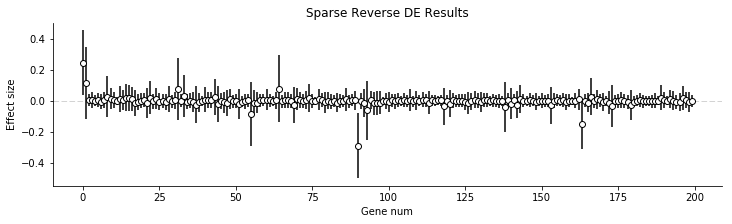

In [25]:
figsize(12, 3)
plt.errorbar(np.arange(beta.shape[1]), beta.mean(0), yerr=2*beta.std(0), fmt='o', color='k', markerfacecolor='w');
plt.axhline(0, lw=1, ls='--', color='lightgrey', zorder=-1)
plt.xlabel('Gene num')
plt.ylabel('Effect size');
plt.title('Sparse Reverse DE Results');

Now the uncertainty is not very large for most of the genes! A small number of the genes have larger effect sizes, though with pretty large CI's. We can look at the volcano plot to get a clearer summary.

In [26]:
pval = np.sum((beta < 0), 0) / beta.shape[0]
pval = np.minimum(pval, 1 - pval)

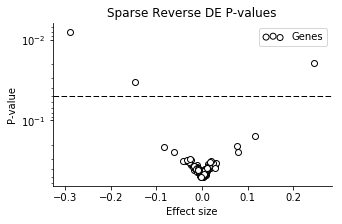

In [27]:
figsize(5, 3)
plt.yscale('log')
plt.scatter(beta.mean(0), np.maximum(pval, 1e-13), c='w', edgecolor='k', label='Genes');
plt.axhline(0.05, lw=1, ls='--', c='k');
plt.gca().invert_yaxis();
plt.ylabel('P-value')
plt.xlabel('Effect size');
plt.legend(scatterpoints=3);
plt.title('Sparse Reverse DE P-values');

Three of the genes have particularly small P-values, in order: mt-Nd2, Dppa5a, Ckb.

I'm not really expecting very relevant results from this analysis, because the noise models are very crude, and I haven't corrected for any technical factors. But Dppa5a is a well known mESC pluripotency marker, and Ckb is known to be highly abundant in brain (NSC's are neural stem cells). While not very scientific, it's fun that it "makes sense".

I just wanted to explore Bayesian thinking in differential expression, and give some small Stan examples on how to investigate small conceptual ideas of this.

This post is available as a notebook [here](https://github.com/vals/ReverseDE/blob/master/Reverse%20DE.ipynb), with all analysis and code.

In [28]:
pd.DataFrame({'pval': pval, 'beta': beta.mean(0)}, index=idx).sort_values('pval').head(10)

,beta,pval
ENSMUSG00000064345,-0.288968,0.0080
ENSMUSG00000060461,0.245447,0.0195
ENSMUSG00000001270,-0.147287,0.0335
ENSMUSG00000057666,0.115933,0.1545
ENSMUSG00000064358,0.077362,0.2100
ENSMUSG00000008682,-0.084028,0.2115
ENSMUSG00000052551,0.078640,0.2435
ENSMUSG00000060126,-0.061452,0.2490
ENSMUSG00000049421,-0.025748,0.2990
ENSMUSG00000029580,-0.033113,0.3105


In [29]:
for g in _.index:
    print(g)

ENSMUSG00000064345
ENSMUSG00000060461
ENSMUSG00000001270
ENSMUSG00000057666
ENSMUSG00000064358
ENSMUSG00000008682
ENSMUSG00000052551
ENSMUSG00000060126
ENSMUSG00000049421
ENSMUSG00000029580
